In [8]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Settings
OUTPUT_DIR = 'charts'
os.makedirs(OUTPUT_DIR, exist_ok=True)
np.random.seed(42)

In [9]:
# --- Generate synthetic data ---
N = 1000  # Number of hourly data points
outdoor_temp = np.random.uniform(10, 35, N)
time_of_day = np.random.randint(0, 24, N)
occupants = np.random.randint(1, 6, N)
thermostat_set = np.random.uniform(19, 24, N)

consumption = (
    0.5 * outdoor_temp
    + 0.1 * time_of_day
    + 0.8 * occupants
    - 0.2 * thermostat_set
    + 5  # bias/baseline
    + np.random.normal(0, 2, N)  # noise
)
consumption = np.maximum(0, consumption)

data = pd.DataFrame({
    'OutdoorTemp': outdoor_temp,
    'TimeOfDay': time_of_day,
    'Occupants': occupants,
    'ThermostatSet': thermostat_set,
    'Consumption_kWh': consumption,
})

data.head()

,OutdoorTemp,TimeOfDay,Occupants,ThermostatSet,Consumption_kWh
0,19.363503,14,3,20.175186,13.571498
1,33.767858,11,3,23.153443,22.870728
2,28.299849,15,4,21.724138,19.909206
3,24.966462,23,5,19.826210,21.122766
4,13.900466,18,4,21.914922,12.882144


In [10]:
# --- Filtering / outlier handling ---
upper_bound = data['Consumption_kWh'].quantile(0.99)
data_filtered = data[data['Consumption_kWh'] < upper_bound].copy()
print(f'Original rows: {len(data)}, After filtering: {len(data_filtered)}, Threshold: {upper_bound:.2f}')
data_filtered.describe()

Original rows: 1000, After filtering: 990, Threshold: 25.03


,OutdoorTemp,TimeOfDay,Occupants,ThermostatSet,Consumption_kWh
count,990.000000,990.000000,990.000000,990.000000,990.000000
mean,22.152282,11.262626,3.049495,21.594219,15.248575
std,7.264105,6.840056,1.420126,1.420694,4.348346
min,10.115801,0.000000,1.000000,19.002214,3.213802
25%,15.742681,5.000000,2.000000,20.408024,11.895947
50%,22.330259,11.000000,3.000000,21.659777,15.253022
75%,28.361158,17.000000,4.000000,22.810019,18.527461
max,34.992942,23.000000,5.000000,23.998569,25.030450


In [11]:
# --- Train a simple Linear Regression and evaluate ---
X = data_filtered[['OutdoorTemp', 'TimeOfDay', 'Occupants', 'ThermostatSet']]
y = data_filtered['Consumption_kWh']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Model metrics on test set:')
print('  MSE: {:.3f}'.format(mean_squared_error(y_test, y_pred)))
print('  R2 : {:.3f}'.format(r2_score(y_test, y_pred)))

pd.DataFrame({'feature': X.columns, 'coef': model.coef_})

Model metrics on test set:
  MSE: 3.519
  R2 : 0.793


,feature,coef
0,OutdoorTemp,0.493680
1,TimeOfDay,0.099855
2,Occupants,0.830272
3,ThermostatSet,-0.210408


Saved: charts/consumption_histogram.png


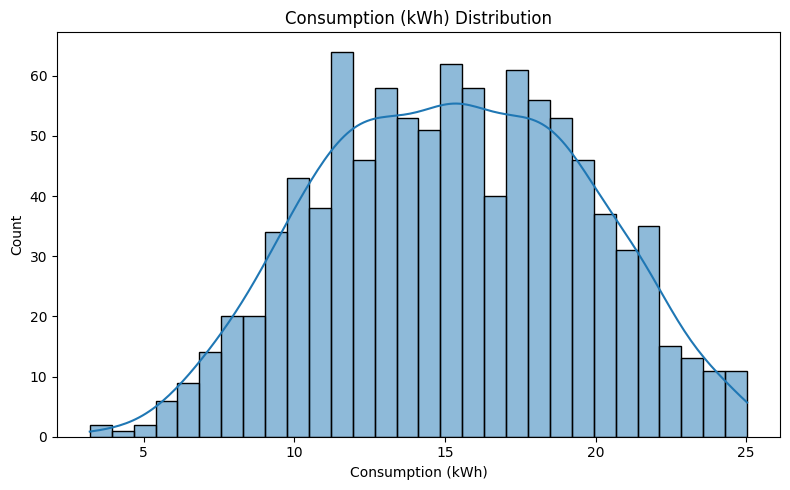

Saved: charts/temp_vs_consumption.png


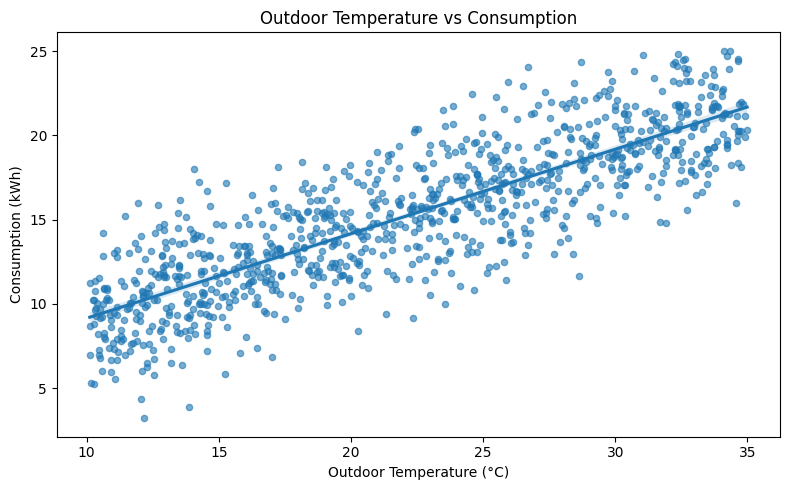

Saved: charts/consumption_by_hour_boxplot.png


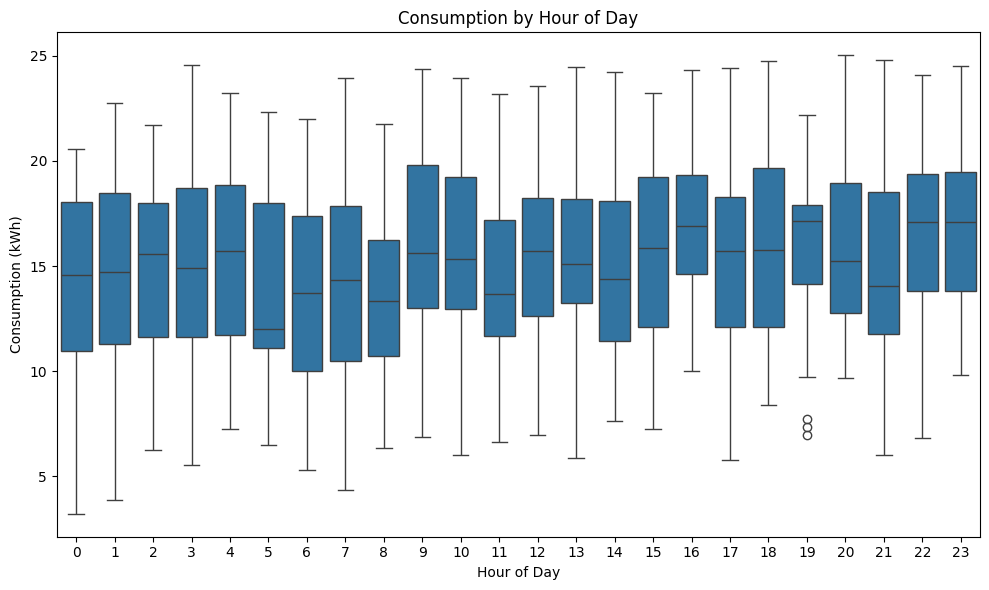

Saved: charts/correlation_heatmap.png


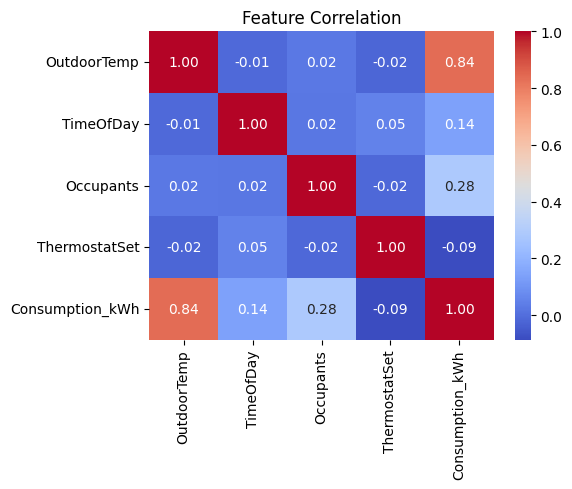

In [12]:
# --- Plots (they will also be saved to `charts/`) ---
import matplotlib.ticker as ticker

plt.figure(figsize=(8,5))
sns.histplot(data_filtered['Consumption_kWh'], bins=30, kde=True)
plt.title('Consumption (kWh) Distribution')
plt.xlabel('Consumption (kWh)')
plt.tight_layout()
fn = os.path.join(OUTPUT_DIR, 'consumption_histogram.png')
plt.savefig(fn)
print('Saved:', fn)
plt.show()

plt.figure(figsize=(8,5))
sns.regplot(x='OutdoorTemp', y='Consumption_kWh', data=data_filtered, scatter_kws={'s':20, 'alpha':0.6})
plt.title('Outdoor Temperature vs Consumption')
plt.xlabel('Outdoor Temperature (°C)')
plt.ylabel('Consumption (kWh)')
plt.tight_layout()
fn = os.path.join(OUTPUT_DIR, 'temp_vs_consumption.png')
plt.savefig(fn)
print('Saved:', fn)
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='TimeOfDay', y='Consumption_kWh', data=data_filtered)
plt.title('Consumption by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Consumption (kWh)')
plt.tight_layout()
fn = os.path.join(OUTPUT_DIR, 'consumption_by_hour_boxplot.png')
plt.savefig(fn)
print('Saved:', fn)
plt.show()

plt.figure(figsize=(6,5))
corr = data_filtered[['OutdoorTemp','TimeOfDay','Occupants','ThermostatSet','Consumption_kWh']].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation')
plt.tight_layout()
fn = os.path.join(OUTPUT_DIR, 'correlation_heatmap.png')
plt.savefig(fn)
print('Saved:', fn)
plt.show()

In [13]:
# --- If a real dataset exists, preview it ---
csv_path = 'energydata_complete.csv'
if os.path.exists(csv_path):
    print('Found `energydata_complete.csv` in workspace. Showing a quick preview:')
    try:
        df_real = pd.read_csv(csv_path)
        display(df_real.head())
    except Exception as e:
        print('Failed to read real CSV:', e)
else:
    print('No `energydata_complete.csv` found in the workspace root.')

Found `energydata_complete.csv` in workspace. Showing a quick preview:


,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097
